# Voice Control with PSoC 6

In [ ]:
# Note:
# This notebook is derived from TensorFlow's simple_audio tutorial and modified accordingly for Voice Control with PSoC 6.
# https://www.tensorflow.org/tutorials/audio/simple_audio

###### Copyright 2020 The TensorFlow Authors.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set this to True to install requirements
INSTALL_REQ = True

# Set this to True to download dataset
DOWNLOAD_DATASET = True

# Set this to True to unzip dataset
UNZIP_DATASET = True

# Dataset download link
DATASET_LINK = "https://drive.google.com/uc?id=1ZdbFST-oRXiVY1yzjV1ZxLNLIDGICsFS"

# Path to your mounted google drive
GDRIVE_LOC = "/content/drive/MyDrive"

# Working directory in google drive
WORKING_LOC = "/iHack_UR"

# Full working path
FULL_WORKING_LOC = GDRIVE_LOC + WORKING_LOC

# Path to extract dataset
DATASET_PATH = FULL_WORKING_LOC + "/dataset_ihack"

In [ ]:
if INSTALL_REQ:
  !pip install git+https://github.com/ARM-software/CMSIS_5.git@5.9.0#egg=CMSISDSP\&subdirectory=CMSIS/DSP/
  !sudo apt-get install libportaudio2
  !pip install audiomentations
  !pip install sounddevice
  !pip install python_speech_features
  !pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ARM-software/CMSIS_5.git (to revision 5.9.0) to /tmp/pip-install-fcgvzmah/cmsisdsp_97e14d15d19a45e895ebd64416fdba5c
  Running command git clone -q https://github.com/ARM-software/CMSIS_5.git /tmp/pip-install-fcgvzmah/cmsisdsp_97e14d15d19a45e895ebd64416fdba5c
  Running command git checkout -q 61e36449f53c25ef7825c40f7dd93685736f457f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for CMSISDSP: filename=cmsisdsp-1.4.0-cp37-cp37m-linux_x86_64.whl size=2795180 sha256=ecc75abeeaad77c08e558bfa429c56c0860cfad7722651b298e6727f51fb1da2
  Stored in directory: /tmp/pip-ephem-wheel-cache-_n4x1mop/wheels/63/b1/47/10eb484c9028d6ba75217a5cd71ccfed582a406a9a38751ef9
Successfully built CMSISDSP
Reading package lists... Done
Building dependency tree       
Reading state information... 

In [ ]:
if DOWNLOAD_DATASET:
  !rm -rf /content/drive/MyDrive/iHack_UR

  import os
  import gdown

  os.mkdir(FULL_WORKING_LOC)

  # a file
  url = DATASET_LINK
  output = FULL_WORKING_LOC + "/dataset.zip"
  gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ZdbFST-oRXiVY1yzjV1ZxLNLIDGICsFS
To: /content/drive/MyDrive/iHack_UR/dataset.zip
100%|██████████| 202M/202M [00:01<00:00, 102MB/s]


In [ ]:
if UNZIP_DATASET:
  import zipfile
  with zipfile.ZipFile(FULL_WORKING_LOC + "/dataset.zip", 'r') as zip_ref:
    zip_ref.extractall(DATASET_PATH)

### Import Python Packages

In [ ]:
# Import required packages

import os
import pathlib
from IPython import display

import cmsisdsp
from cmsisdsp.datatype import F32
import cmsisdsp.fixedpoint as f
import cmsisdsp.mfcc as cmsismfcc

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import numpy as np
from numpy import pi as PI

import scipy.signal as sig
from scipy.io.wavfile import write

import seaborn as sns

import matplotlib.pyplot as plt

import pandas as pd

from audiomentations import SpecCompose, SpecFrequencyMask
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift,AddBackgroundNoise,AddShortNoises
import sounddevice as sd
import python_speech_features
from tensorflow.python.ops import gen_audio_ops as audio_ops

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
tf.__version__

'2.8.2'

## Import the dataset

In [ ]:
data_dir = pathlib.Path(DATASET_PATH)

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
commands = commands[commands != 'LICENSE']
print('Commands:', commands)

Commands: ['off' 'on' 'silence']


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
[print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[itr])))) for itr in range(len(commands))]
print('Example file tensor:', filenames[0])

Number of total examples: 9590
Number of examples per label: 3745
Number of examples per label: 3845
Number of examples per label: 2000
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/iHack_UR/dataset_ihack/off/3a3ee7ed_nohash_4.wav', shape=(), dtype=string)


Split `filenames` into training, validation and test sets using a 80:10:10 ratio, respectively:

In [ ]:
trainset_80p=num_samples*(80/100)
if (trainset_80p%10 != 0):
    trainset_80p=int(trainset_80p)+1
else:
    trainset_80p=int(trainset_80p)
testset_10p=int(num_samples*(10/100))
print("train set",trainset_80p)
print("test set",testset_10p)
total_set=trainset_80p+testset_10p*2
print("Total set, num samples",total_set,num_samples)

train set 7673
test set 959
Total set, num samples 9591 9590


In [ ]:
train_files = filenames[:trainset_80p]
val_files = filenames[trainset_80p: trainset_80p + testset_10p]
test_files = filenames[-testset_10p:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 7673
Validation set size 959
Test set size 959


## Read the audio files and their labels

In [ ]:
def decode_audio(audio_binary):
    audio, sampling_rate = tf.audio.decode_wav(contents=audio_binary)  # Decode a 16-bit PCM WAV file to a float tensor.
    print(audio.shape)
    return tf.squeeze(audio, axis=-1)

In [ ]:
def get_label(file_path):
    parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
    return parts[-2]

In [ ]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    print("file path",file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    print(label.shape, waveform.shape)
    return waveform, label

## Create a Training TensorFlow Dataset

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(
    map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)

file path Tensor("args_0:0", shape=(), dtype=string)
(None, None)
() (None,)


## Plot the Audio waveforms

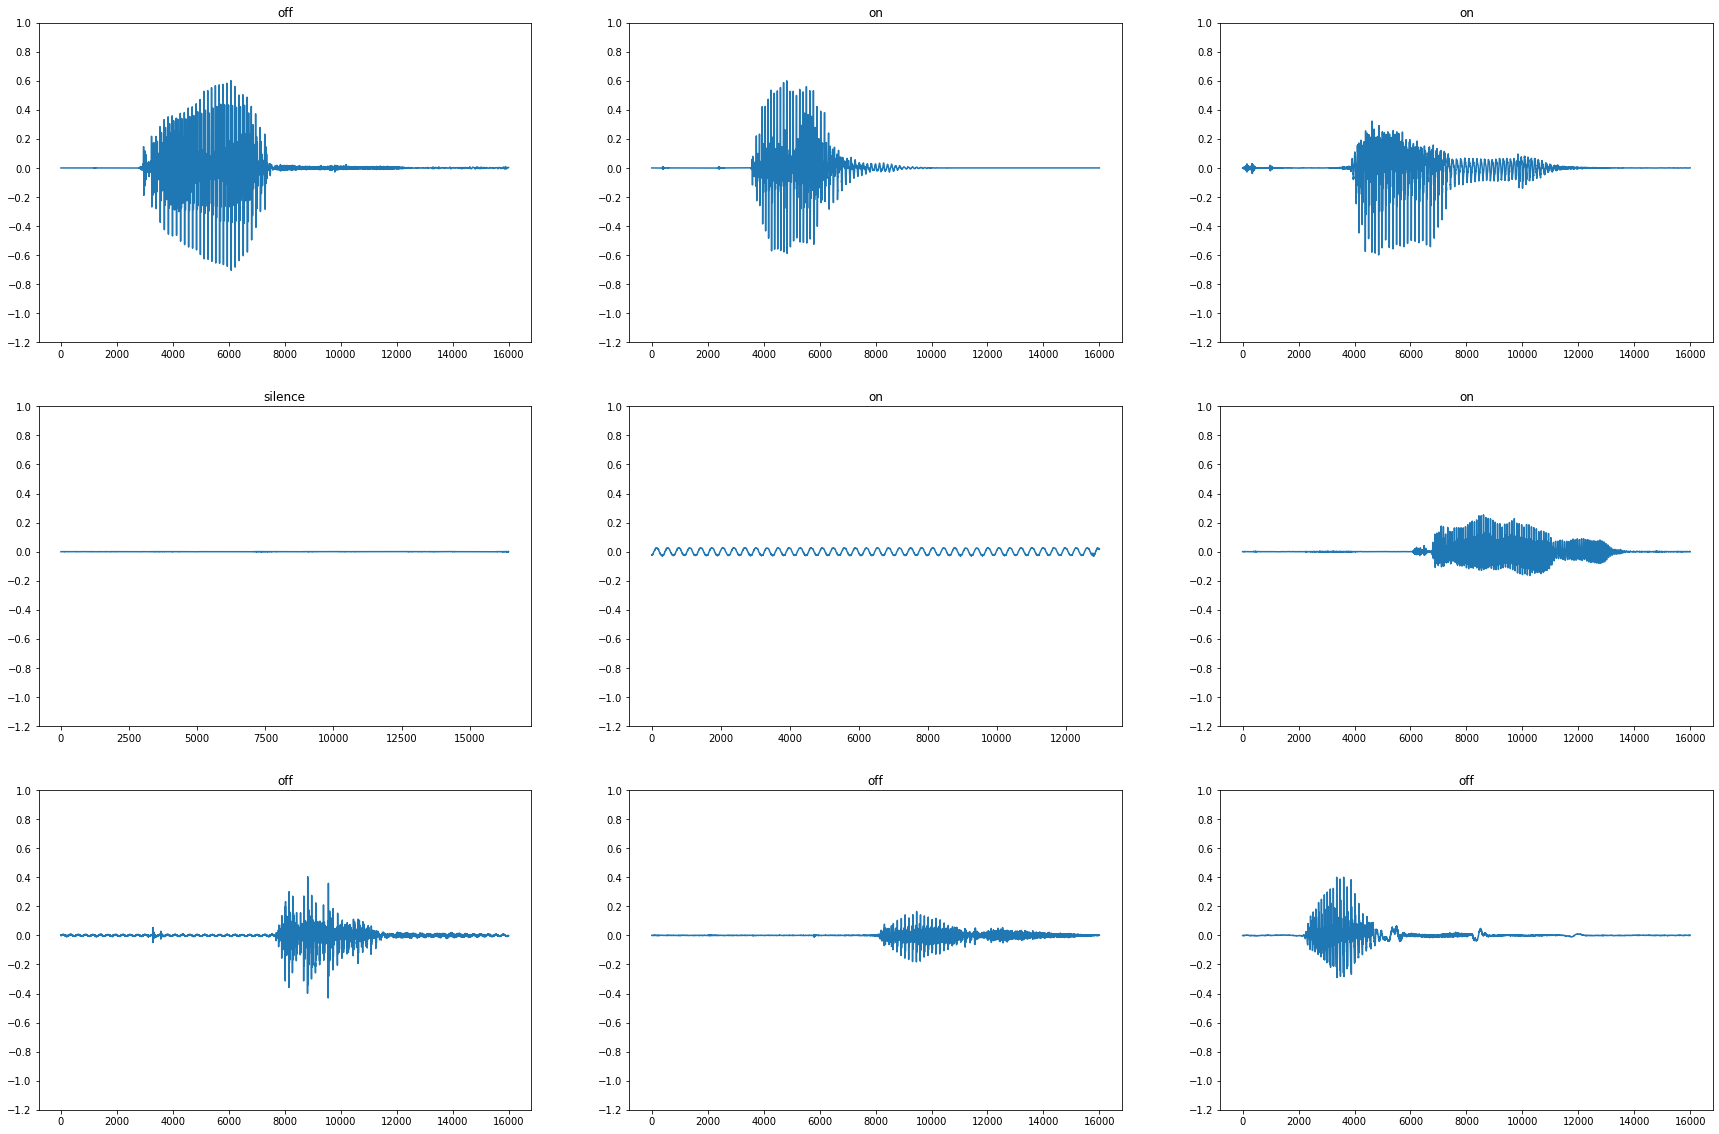

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(30, 20))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

## Augment and convert audio data to MFCC

We will augment the data using augmentations package and convert it to MFCC using ARM CMSIS DSP API's.

### Audio Augmentation

In [ ]:
DEMO_DIR = DATASET_PATH

augment_waveform_pipeline = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.05, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])


@tf.function
def tf_augment_wave(waveform):
    pipeline = tf.numpy_function(augment_waveform,[waveform],Tout=tf.float32)
    return pipeline

def augment_waveform(waveform):
    print("augment waveform shape",waveform.shape)
    aug_waveform=augment_waveform_pipeline(samples=waveform,sample_rate=16000)
    print("Augmented shape",aug_waveform.shape)
    return aug_waveform


@tf.function
def tf_augment_wave_to_mfcc(waveform,label):
    label_id = tf.argmax(label == commands)
    return tf.numpy_function(augment_waveform_to_mfcc,[waveform],Tout=tf.float32),label_id

def augment_waveform_to_mfcc(waveform):
    aug_waveform=augment_waveform_pipeline(samples=waveform,sample_rate=16000)
    aug_mfcc=get_cmsis_mfcc_full(aug_waveform)
    return aug_mfcc

## Feature Extraction - MFCC (Mel-Frequency Cepstral Coefficients)

In [ ]:
# MFCC configuration parameters

# Fixed parameters
sampling_rate = 16000
freq_min = 64
freq_high = sampling_rate / 2 # Nyquist rate

# Configurable parameters
FFT_size = 820
FFT_step_size = 1024
num_dct_outputs = 5
num_mel_filters = 40


In [ ]:
mfccf32 = cmsisdsp.arm_mfcc_instance_f32()
window = sig.hamming(FFT_size, sym=False)
filtLen,filtPos,packedFilters = cmsismfcc.melFilterMatrix(F32,freq_min, freq_high, num_mel_filters,sampling_rate,FFT_size)
dctMatrixFilters = cmsismfcc.dctMatrix(F32,num_dct_outputs, num_mel_filters)    

status = cmsisdsp.arm_mfcc_init_f32(mfccf32,FFT_size,num_mel_filters,num_dct_outputs,dctMatrixFilters,filtPos,filtLen,packedFilters,window)

@tf.function
def get_cmsis_mfcc_ds(waveform):
    return tf.numpy_function(get_cmsis_mfcc_full,[waveform],Tout=tf.float32)


def get_cmsis_mfcc_full(waveform):  
    input_len = 16384
    waveform = waveform[:input_len] 
    
    zero_padding = tf.zeros(
      [input_len] - tf.shape(waveform),
      dtype=tf.float32)
    
    initial_zero_padding=tf.zeros(FFT_size - FFT_step_size, dtype=tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    
    # Concatenate the waveform with `zero_padding`, which ensures all audio clips are of the same length.
    equal_length = tf.concat([initial_zero_padding, waveform, zero_padding], 0)
      
    mfcc_full=np.empty(shape=[0,num_dct_outputs],dtype=np.float32)
    
    equal_length=equal_length.numpy()

    start_index=0 
    while start_index<=(len(equal_length)-FFT_size):
        tmp=np.zeros(FFT_size + 2)
        mfcc_res=cmsisdsp.arm_mfcc_f32(mfccf32,equal_length[start_index:start_index+FFT_size],tmp)
        mfcc_full=np.vstack([mfcc_full,mfcc_res])
        start_index=start_index+FFT_step_size
        
    mfcc_full=mfcc_full[...,tf.newaxis]
    mfcc_full=tf.image.per_image_standardization(mfcc_full)
    return mfcc_full

## Playback Audio

In [ ]:
for waveform, label in waveform_ds.take(1):
    print("wave")
    print(len(waveform))
    label = label.numpy().decode('utf-8')
    mfcc_arm=get_cmsis_mfcc_full(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print("MFCC shape",mfcc_arm.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

wave
16000
Label: off
Waveform shape: (16000,)
MFCC shape (16, 5, 1)
Audio playback


In [ ]:
aug_waveform=tf_augment_wave(waveform)
display.display(display.Audio(aug_waveform, rate=16000))

augment waveform shape (16000,)
Augmented shape (16000,)


## Plot the Spectrogram

In [ ]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        print("before squeeze",spectrogram.shape)
        spectrogram = np.squeeze(spectrogram, axis=-1)
        print("after squeeze",spectrogram.shape)

    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec =(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = range(width)
    Y = range(height)
    print("size spectrogram",np.size(spectrogram))
    print("Width",width, "Height",height)
    ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

before squeeze (16, 5, 1)
after squeeze (16, 5)
size spectrogram 80
Width 16 Height 5


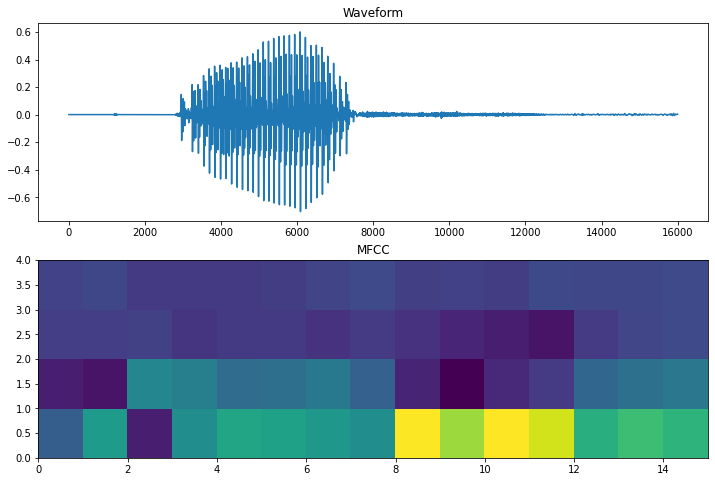

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
plot_spectrogram(mfcc_arm,axes[1])
axes[1].set_title("MFCC")
plt.show()

## Training DS with Spectrograms and Labels

In [ ]:
def get_mfcc_label_id(audio,label):
    mfcc=get_cmsis_mfcc_ds(audio)
    label_id=tf.argmax(label==commands)
    return mfcc, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(map_func=get_mfcc_label_id)

In [ ]:
augmented_spec_ds = waveform_ds.map(map_func=tf_augment_wave_to_mfcc)

## Prepare the training DataSet with Actual+Augmented data and Test,Validation DataSets

In [ ]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds=files_ds.map(map_func=get_waveform_and_label)
    output_ds=output_ds.map(map_func=get_mfcc_label_id)
    return output_ds

In [ ]:
train_ds = spectrogram_ds.concatenate(augmented_spec_ds)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

file path Tensor("args_0:0", shape=(), dtype=string)
(None, None)
() (None,)
file path Tensor("args_0:0", shape=(), dtype=string)
(None, None)
() (None,)


In [ ]:
# Check for number of elements in the training dataset
num_of_samples=train_ds.cardinality().numpy()
print(num_of_samples)

15346


In [ ]:
train_shuffle_ds=train_ds.shuffle(num_of_samples,reshuffle_each_iteration=True)
batch_size = 64
train_ds = train_shuffle_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache()
val_ds = val_ds.cache()

## Neural Network Model

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape

num_labels = len(commands)

model = models.Sequential([
    
    layers.Input(shape=input_shape),
    
    layers.Conv2D(32,(8,8),strides=(1,1),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.AveragePooling2D(),
 
    layers.Conv2D(16,3,strides=(1,1),padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.AveragePooling2D(),

    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(num_labels, kernel_regularizer='l2', activation='softmax'),
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 5, 32)         2080      
                                                                 
 batch_normalization (BatchN  (None, 16, 5, 32)        128       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 8, 2, 32)         0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 2, 16)          4624      
                                                                 
 batch_normalization_1 (Batc  (None, 8, 2, 16)         64        
 hNormalization)                                                 
                                                        

## Compile and Fit the Model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='accuracy',mode='max',verbose=1, patience=4),
)

Epoch 1/100
240/240 [==============================] - 249s 38ms/step - loss: 0.7001 - accuracy: 0.7116 - val_loss: 0.9462 - val_accuracy: 0.6309
Epoch 2/100
240/240 [==============================] - 4s 17ms/step - loss: 0.4693 - accuracy: 0.8248 - val_loss: 0.3989 - val_accuracy: 0.9103
Epoch 3/100
240/240 [==============================] - 4s 17ms/step - loss: 0.4020 - accuracy: 0.8543 - val_loss: 0.2901 - val_accuracy: 0.9270
Epoch 4/100
240/240 [==============================] - 4s 17ms/step - loss: 0.3649 - accuracy: 0.8695 - val_loss: 0.2305 - val_accuracy: 0.9197
Epoch 5/100
240/240 [==============================] - 6s 26ms/step - loss: 0.3335 - accuracy: 0.8796 - val_loss: 0.2016 - val_accuracy: 0.9426
Epoch 6/100
240/240 [==============================] - 4s 17ms/step - loss: 0.3167 - accuracy: 0.8880 - val_loss: 0.2013 - val_accuracy: 0.9364
Epoch 7/100
240/240 [==============================] - 4s 16ms/step - loss: 0.3069 - accuracy: 0.8869 - val_loss: 0.2014 - val_accurac

## Plot the Loss

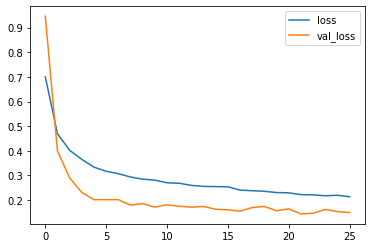

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 95%


In [ ]:
model.evaluate(test_audio, test_labels)

30/30 [==============================] - 0s 6ms/step - loss: 0.1356 - accuracy: 0.9489


[0.13559721410274506, 0.9489051103591919]

## Display the confusion matrix


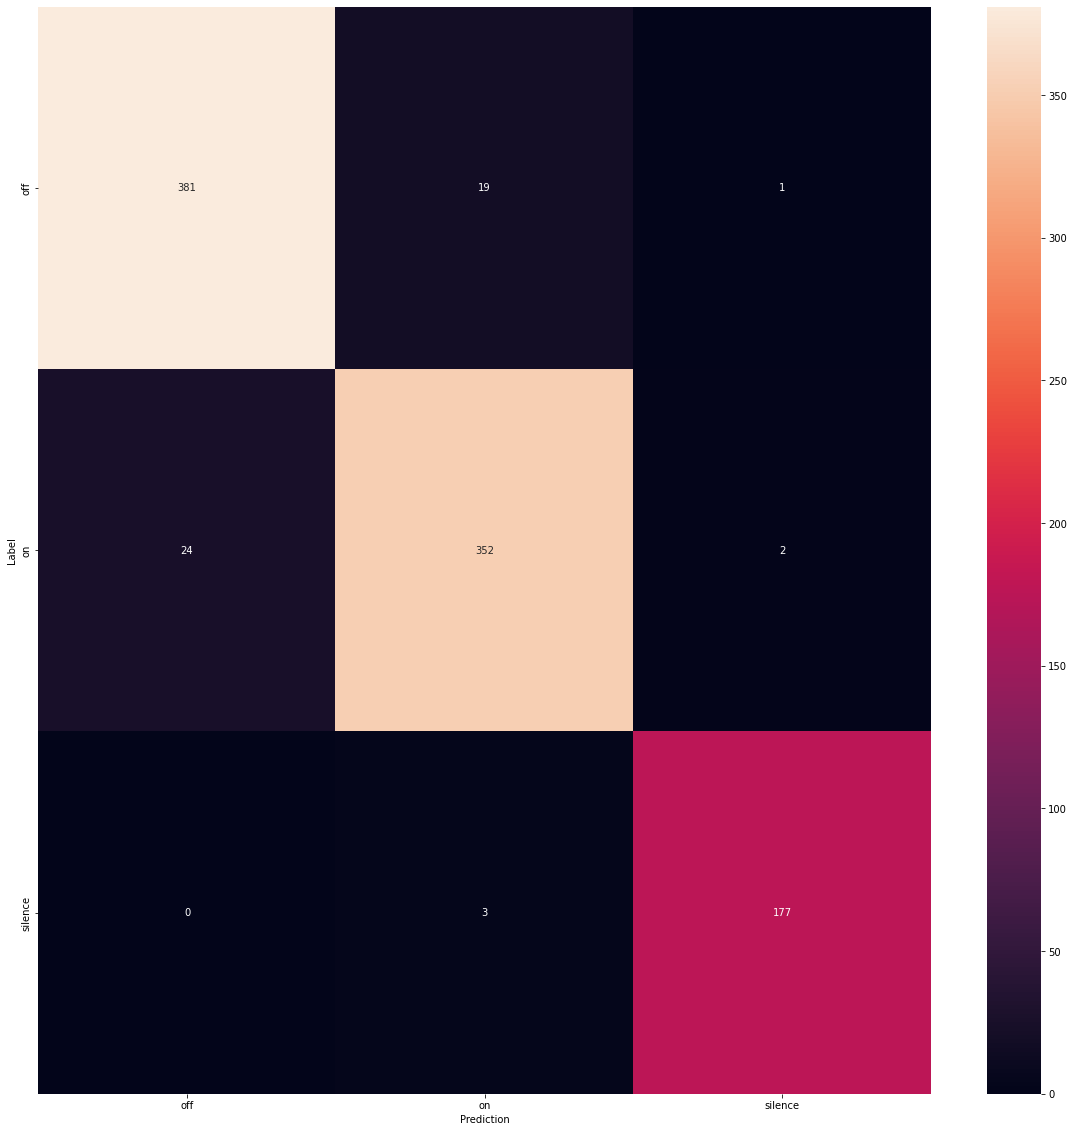

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20,20))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Save the Model

In [ ]:
# Save the model as h5 file.
model.save(FULL_WORKING_LOC + "/psoc6_voice_control_bootcamp_model_cnn.h5")

In [ ]:
# all imports
from IPython.display import display, Javascript
from google.colab import output
from base64 import b64decode

REC = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(REC))
  print('Speak now!')
  s = output.eval_js('record(%d)' % (sec*1000))
  print('Audio captured')
  b = b64decode(s.split(',')[1])
  with open("/content/drive/MyDrive/iHack_UR/voice.ogg",'wb') as f:
    f.write(b)
  return "/content/drive/MyDrive/iHack_UR/voice.ogg"

<IPython.core.display.Javascript object>

Speak now!
Audio captured
(15360, 1)
Predicted off


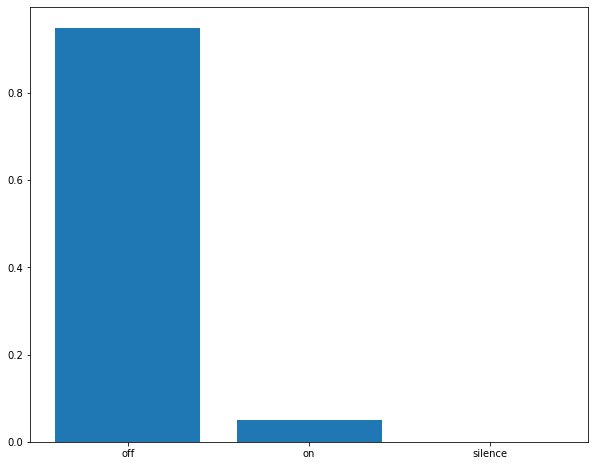

In [ ]:
record(1)
!ffmpeg -loglevel panic -y -i /content/drive/MyDrive/iHack_UR/voice.ogg /content/drive/MyDrive/iHack_UR/voice.wav
!ffmpeg -loglevel panic -y -i /content/drive/MyDrive/iHack_UR/voice.wav -ar 16000 /content/drive/MyDrive/iHack_UR/voice_16k.wav
x = tf.io.read_file("/content/drive/MyDrive/iHack_UR/voice_16k.wav")
waveform = decode_audio(x)
sample_ds=get_cmsis_mfcc_full(waveform)
sample_ds = sample_ds[tf.newaxis,...]
prediction = model(sample_ds)
plt.figure(figsize=(10,8))
print("Predicted",commands[tf.math.argmax(prediction[0])])
plt.bar(commands, prediction[0])
plt.show()